# Classification of Breast Cancer Data using an ANN (Multilayer Perceptron from Keras)

This notebook uses an ANN from Keras (Multi-layer perceptron) to classify breast cancer cases as malign or bening based on the breast measuremens taken.

I wrote the wrapper function load_preprocessed_bcd() to load and clean the data (e.g. removal of NaN values). The wrapper function additionally performs three dimensionality reduction approaches and returns four dataframes corresponding to:

1. Data with the original dimensionality.
2. Dimensionality reduction by using hypothesis testing (features with significant differences between the malign and benign groups).
3. Dimensionality reduction using PCA.
4. Dimensionality reduction using feature-target correlation to measure relevance and feature-feature correlation to measure redundance.

The data is split into 80% training, 10% validation and 10% test set.

<br><br>
## Results from all dimensionality reduction data-sets:
#### All Features
Training set accuracy:  1.0<br>
Test set accuracy:  0.964<br>
<br>
#### Hypothesis Features
Training set accuracy:  0.982<br>
Test set accuracy:  0.947<br>
<br>
#### PCA Features
Training set accuracy:  0.982<br>
Test set accuracy:  0.982<br>
<br>
#### Correlation Features
Training set accuracy:  0.964<br>
Test set accuracy:  0.947<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import tensorflow as tf
import keras

from load_preprocessed_bcd import load_preprocessed_bcd
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

print(tf.__version__)
print(keras.__version__)


2.15.0
2.15.0


# Load pre-processed breast cancer dataset using the wrapper function load_preprocessed_bcd()
### The wrapper function returns four different dataframes. 

### All dataframes share these characteristics:
- Data belongs to the breast cancer dataset.
- Data is free of Null values.
- Data is standardized using the Z-score.

### Each dataframe differs by the dimensionality reduction used on it:
- df_scaled: all features are kept
- df_hypo: the kept features are those that show a significant difference (Mann Whitney-U test, p<0.001) between the groups Benign and Malign.
- df_pca: tHe kept features are the prinicpal components that account for 95% of the data's variance.
- df_correl: the kept features show a correlation with the target higher than 0.2, and a correlation with each other below 0.7

In [2]:
%%capture
df_scaled, df_hypo, df_pca, df_correl = load_preprocessed_bcd()

# 1. Use all features to discern between benign and malign breast measurements

In [3]:
X = df_scaled.drop(columns=['diagnosis'])
y = np.round(df_scaled['diagnosis']=='M').astype(int)

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.20, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=0)

print("Nr. Features: ", X.shape[1])
print("Nr. test events: ", X_test.shape[0])
print("Nr. validation events: ", X_valid.shape[0])
print("Nr. train events: ", X_train.shape[0])

Nr. Features:  30
Nr. test events:  57
Nr. validation events:  57
Nr. train events:  455


## Train the Keras sequential ANN (MLP) without any regularization

In [4]:
hidden_num_nodes = X_train.shape[1]*2

# Integer or None. Number of samples per gradient update
batch_size = 32

# Number of epochs to train the model. 
# An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None).
nr_epochs = 100

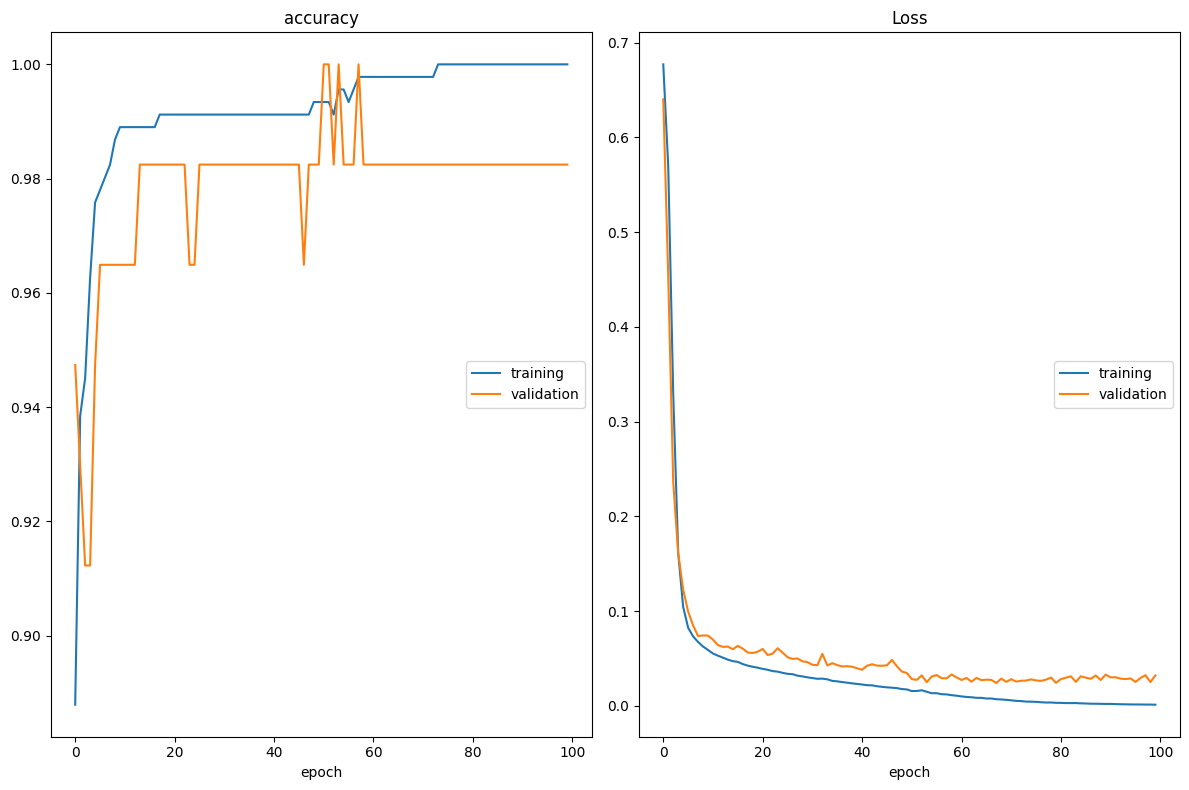

accuracy
	training         	 (min:    0.888, max:    1.000, cur:    1.000)
	validation       	 (min:    0.912, max:    1.000, cur:    0.982)
Loss
	training         	 (min:    0.001, max:    0.677, cur:    0.001)
	validation       	 (min:    0.024, max:    0.640, cur:    0.032)
2/2 [==============================] - 0s 2ms/step

Matthews Correlation Coefficient
Training MCC = 0.9633432944855655
Test MCC = 0.9648363026488436

F1 Score
Training F1 = 0.9767441860465116
Test F1 = 0.9795918367346939

Accuracy
Training Accuracy = 0.9824561403508771
Test Accuracy = 0.9824561403508771


In [5]:
model = Sequential()
input_layer = Input(shape=(X_train.shape[1]))
model.add(input_layer)

hidden_layer = Dense(units = hidden_num_nodes, activation='relu', kernel_initializer='uniform')
model.add(hidden_layer)

hidden_layer = Dense(units = hidden_num_nodes, activation='relu', kernel_initializer='uniform')
model.add(hidden_layer)

output_layer = Dense(units = 1, activation='sigmoid', kernel_initializer='uniform')
model.add(output_layer)

print(model.summary())

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nr_epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[PlotLossesKeras()],
          verbose=0)

#Make predictions on the test data with the trained model
y_predicted = np.round(model.predict(X_test)>0.5)

#tf.math.confusion_matrix(y_test, tf_class_pred)
y_predicted_train = np.round(model.predict(X_valid)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_valid, y_predicted_train).ravel()
train_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
train_f1score = float(2*tp)/float(2*tp+fp+fn)
train_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

y_predicted_test = np.round(model.predict(X_test)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_test, y_predicted_test).ravel()
test_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
test_f1score = float(2*tp)/float(2*tp+fp+fn)
test_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

print("\nMatthews Correlation Coefficient")
print("Training MCC =", train_mcc)
print("Test MCC =", test_mcc)
print("\nF1 Score")
print("Training F1 =", train_f1score)
print("Test F1 =", test_f1score)
print("\nAccuracy")
print("Training Accuracy =", train_accuracy)
print("Test Accuracy =", test_accuracy)

## Train the same ANN but using L2 Regularization

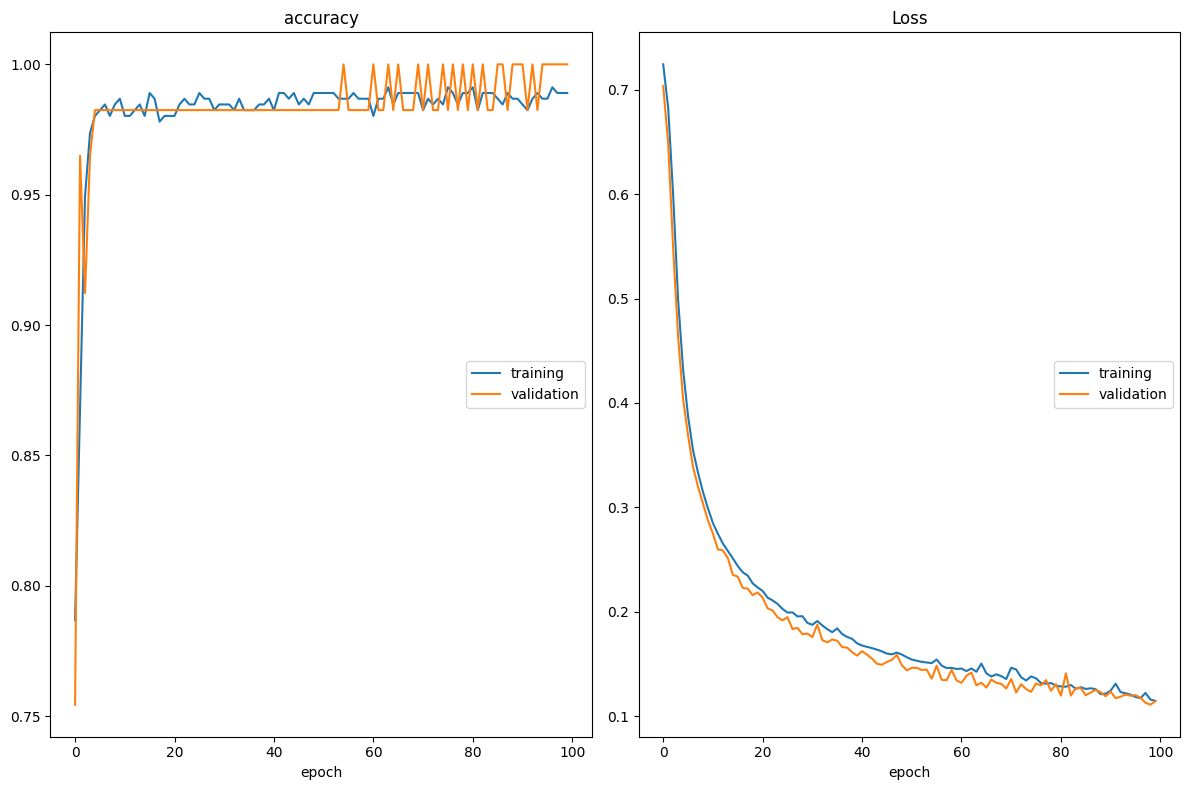

accuracy
	training         	 (min:    0.787, max:    0.991, cur:    0.989)
	validation       	 (min:    0.754, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.115, max:    0.725, cur:    0.115)
	validation       	 (min:    0.111, max:    0.704, cur:    0.114)
2/2 [==============================] - 0s 2ms/step

Matthews Correlation Coefficient
Training MCC = 1.0
Test MCC = 0.92875

F1 Score
Training F1 = 1.0
Test F1 = 0.96

Accuracy
Training Accuracy = 1.0
Test Accuracy = 0.9649122807017544


In [6]:
model = Sequential()

# Input layer
input_layer = Input(shape=(X_train.shape[1]))
model.add(input_layer)

# Hidden layer
model.add(Dense(units=hidden_num_nodes, 
                activation='relu', 
                kernel_initializer='uniform', 
                kernel_regularizer=regularizers.L2(1e-2), 
                bias_regularizer=regularizers.L2(1e-2), 
                activity_regularizer=regularizers.L2(1e-2)))

# Hidden layer
model.add(Dense(units=hidden_num_nodes, 
                activation='relu', 
                kernel_initializer='uniform', 
                kernel_regularizer=regularizers.L2(1e-2), 
                bias_regularizer=regularizers.L2(1e-2), 
                activity_regularizer=regularizers.L2(1e-2)))

# Output layer
model.add(Dense(units = 1, activation='sigmoid', kernel_initializer='uniform'))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nr_epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[PlotLossesKeras()],
          verbose=0)

#Make predictions on the test data with the trained model
y_predicted = np.round(model.predict(X_test)>0.5)

#tf.math.confusion_matrix(y_test, tf_class_pred)
y_predicted_train = np.round(model.predict(X_valid)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_valid, y_predicted_train).ravel()
train_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
train_f1score = float(2*tp)/float(2*tp+fp+fn)
train_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

y_predicted_test = np.round(model.predict(X_test)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_test, y_predicted_test).ravel()
test_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
test_f1score = float(2*tp)/float(2*tp+fp+fn)
test_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

print("\nMatthews Correlation Coefficient")
print("Training MCC =", train_mcc)
print("Test MCC =", test_mcc)
print("\nF1 Score")
print("Training F1 =", train_f1score)
print("Test F1 =", test_f1score)
print("\nAccuracy")
print("Training Accuracy =", train_accuracy)
print("Test Accuracy =", test_accuracy)

## Train the same ANN but using L1 Regularization

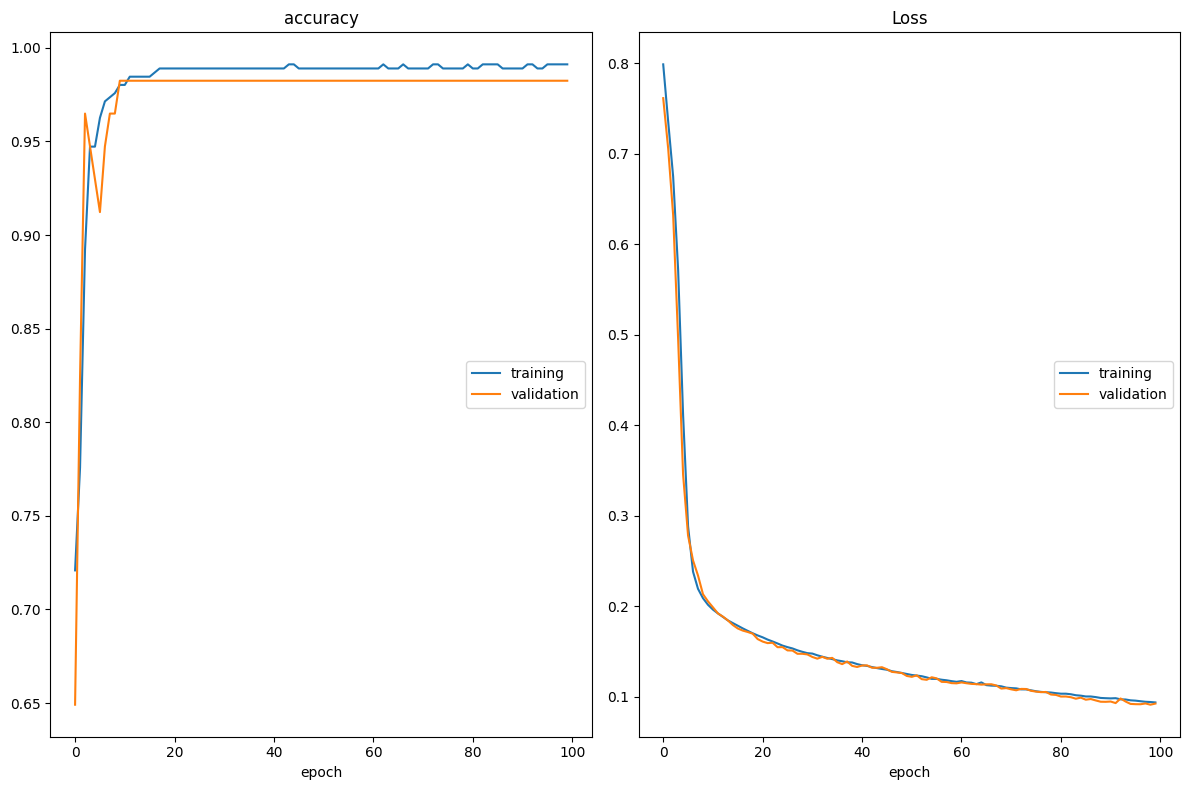

accuracy
	training         	 (min:    0.721, max:    0.991, cur:    0.991)
	validation       	 (min:    0.649, max:    0.982, cur:    0.982)
Loss
	training         	 (min:    0.093, max:    0.799, cur:    0.093)
	validation       	 (min:    0.091, max:    0.762, cur:    0.092)
2/2 [==============================] - 0s 2ms/step

Matthews Correlation Coefficient
Training MCC = 0.9633432944855655
Test MCC = 0.92875

F1 Score
Training F1 = 0.9767441860465116
Test F1 = 0.96

Accuracy
Training Accuracy = 0.9824561403508771
Test Accuracy = 0.9649122807017544


In [7]:
model = Sequential()

# Input layer
input_layer = Input(shape=(X_train.shape[1]))
model.add(input_layer)

# Hidden layer
model.add(Dense(units=hidden_num_nodes, 
                activation='relu', 
                kernel_initializer='uniform', 
                kernel_regularizer=regularizers.L1(1e-3), 
                bias_regularizer=regularizers.L1(1e-3), 
                activity_regularizer=regularizers.L1(1e-3)))

# Hidden layer
model.add(Dense(units=hidden_num_nodes, 
                activation='relu', 
                kernel_initializer='uniform', 
                kernel_regularizer=regularizers.L1(1e-3), 
                bias_regularizer=regularizers.L1(1e-3), 
                activity_regularizer=regularizers.L1(1e-3)))

# Output layer
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='uniform'))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nr_epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[PlotLossesKeras()],
          verbose=0)

#Make predictions on the test data with the trained model
y_predicted = np.round(model.predict(X_test)>0.5)

#tf.math.confusion_matrix(y_test, tf_class_pred)
y_predicted_train = np.round(model.predict(X_valid)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_valid, y_predicted_train).ravel()
train_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
train_f1score = float(2*tp)/float(2*tp+fp+fn)
train_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

y_predicted_test = np.round(model.predict(X_test)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_test, y_predicted_test).ravel()
test_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
test_f1score = float(2*tp)/float(2*tp+fp+fn)
test_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

print("\nMatthews Correlation Coefficient")
print("Training MCC =", train_mcc)
print("Test MCC =", test_mcc)
print("\nF1 Score")
print("Training F1 =", train_f1score)
print("Test F1 =", test_f1score)
print("\nAccuracy")
print("Training Accuracy =", train_accuracy)
print("Test Accuracy =", test_accuracy)

## Train the same ANN but using a Dropout layer at the input for regularization

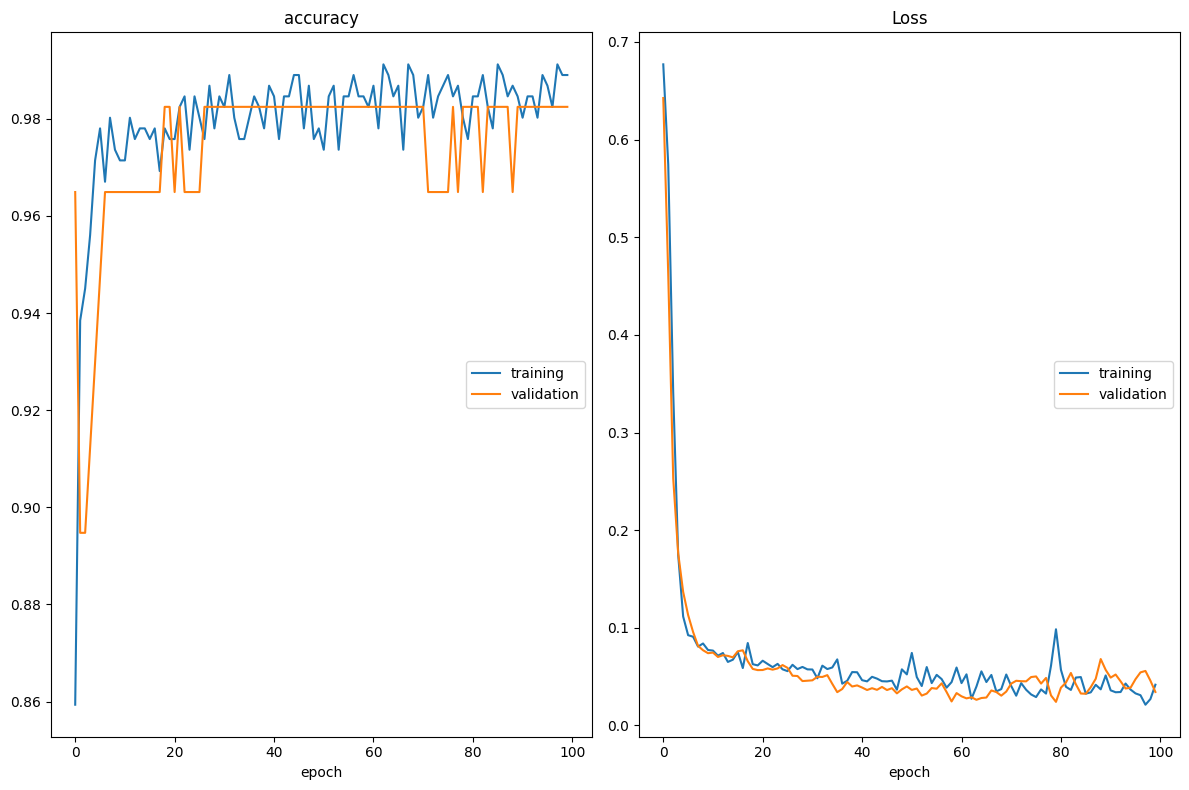

accuracy
	training         	 (min:    0.859, max:    0.991, cur:    0.989)
	validation       	 (min:    0.895, max:    0.982, cur:    0.982)
Loss
	training         	 (min:    0.021, max:    0.677, cur:    0.042)
	validation       	 (min:    0.024, max:    0.643, cur:    0.034)
2/2 [==============================] - 0s 2ms/step

Matthews Correlation Coefficient
Training MCC = 0.9633432944855655
Test MCC = 0.8941531890891586

F1 Score
Training F1 = 0.9767441860465116
Test F1 = 0.9411764705882353

Accuracy
Training Accuracy = 0.9824561403508771
Test Accuracy = 0.9473684210526315


In [16]:
model = Sequential()

# Input layer
model.add(Dropout(0.2, input_shape=(X_train.shape[1],)))

# Hidden layer
model.add(Dense(units=hidden_num_nodes, activation='relu', kernel_initializer='uniform'))
# Hidden layer
model.add(Dense(units=hidden_num_nodes, activation='relu', kernel_initializer='uniform'))

# Output layer
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='uniform'))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nr_epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[PlotLossesKeras()],
          verbose=0)

#Make predictions on the test data with the trained model
y_predicted = np.round(model.predict(X_test)>0.5)

#tf.math.confusion_matrix(y_test, tf_class_pred)
y_predicted_train = np.round(model.predict(X_valid)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_valid, y_predicted_train).ravel()
train_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
train_f1score = float(2*tp)/float(2*tp+fp+fn)
train_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

y_predicted_test = np.round(model.predict(X_test)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_test, y_predicted_test).ravel()
test_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
test_f1score = float(2*tp)/float(2*tp+fp+fn)
test_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

print("\nMatthews Correlation Coefficient")
print("Training MCC =", train_mcc)
print("Test MCC =", test_mcc)
print("\nF1 Score")
print("Training F1 =", train_f1score)
print("Test F1 =", test_f1score)
print("\nAccuracy")
print("Training Accuracy =", train_accuracy)
print("Test Accuracy =", test_accuracy)

## Train the same ANN but using several Dropout layers

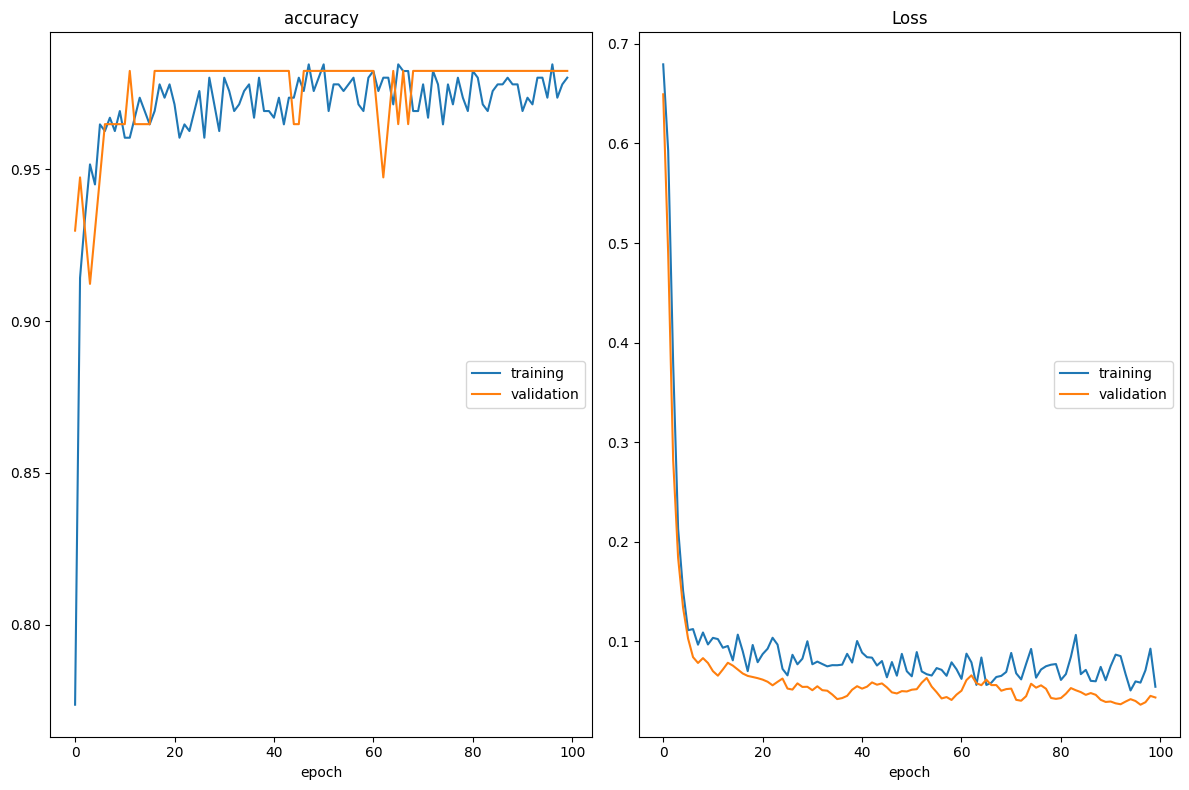

accuracy
	training         	 (min:    0.774, max:    0.985, cur:    0.980)
	validation       	 (min:    0.912, max:    0.982, cur:    0.982)
Loss
	training         	 (min:    0.051, max:    0.679, cur:    0.054)
	validation       	 (min:    0.036, max:    0.649, cur:    0.044)
2/2 [==============================] - 0s 3ms/step

Matthews Correlation Coefficient
Training MCC = 0.9633432944855655
Test MCC = 0.9316949906249123

F1 Score
Training F1 = 0.9767441860465116
Test F1 = 0.9615384615384616

Accuracy
Training Accuracy = 0.9824561403508771
Test Accuracy = 0.9649122807017544


In [18]:
model = Sequential()

# Input layer
model.add(Dropout(0.2, input_shape=(X_train.shape[1],)))
# Droput Layer 1
model.add(Dropout(0.2))

# Hidden layer
model.add(Dense(units=hidden_num_nodes, activation='relu', kernel_initializer='uniform'))
# Droput Layer 2
model.add(Dropout(0.2))

# Hidden layer
model.add(Dense(units=hidden_num_nodes, activation='relu', kernel_initializer='uniform'))
# Droput Layer 3
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='uniform'))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nr_epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[PlotLossesKeras()],
          verbose=0)

#Make predictions on the test data with the trained model
y_predicted = np.round(model.predict(X_test)>0.5)

#tf.math.confusion_matrix(y_test, tf_class_pred)
y_predicted_train = np.round(model.predict(X_valid)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_valid, y_predicted_train).ravel()
train_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
train_f1score = float(2*tp)/float(2*tp+fp+fn)
train_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

y_predicted_test = np.round(model.predict(X_test)>0.5)
(tn, fp, fn, tp) = confusion_matrix(y_test, y_predicted_test).ravel()
test_accuracy = float(tp+tn)/float(tn+fp+fn+tp)
test_f1score = float(2*tp)/float(2*tp+fp+fn)
test_mcc = (float(tp*tn)-float(fp*fn))/np.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))

print("\nMatthews Correlation Coefficient")
print("Training MCC =", train_mcc)
print("Test MCC =", test_mcc)
print("\nF1 Score")
print("Training F1 =", train_f1score)
print("Test F1 =", test_f1score)
print("\nAccuracy")
print("Training Accuracy =", train_accuracy)
print("Test Accuracy =", test_accuracy)